The goal of this project is to use an NLP method to predict house prices in Ames, Iowa based on a dataset of 79 explanatory variables describing (almost) every aspect of residential homes.

In [ ]:
#pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113
#pip install torchviz

In [7]:
# import modules
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import math
import torch, torchvision
from torchviz import make_dot
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from sklearn.model_selection import train_test_split

In [39]:
#load datasets
df_train = pd.read_csv('../input/regression-technique-eda/House Price Regression Tecnique/train.csv')
df_test  = pd.read_csv('../input/regression-technique-eda/House Price Regression Tecnique/test.csv')

# Exploratory Data Analysis

In [30]:
#Describe datasets
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [31]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [40]:
#summarize the data types
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']
print(len(quantitative))
print(len(qualitative))

36
43


There are 1460 rows of training data and 1459 of test data. The target variable is SalePrice, and there are 79 independent variables, including 36  quantitative and 43 categorical variables

In [41]:
#Check missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


19 variables have missing values, and the top 5 missing variables are additional house features such as pool, MiscFeature, alley, and so on. 

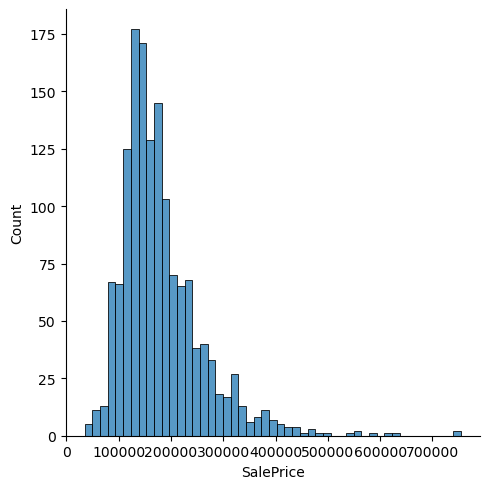

In [42]:
#take a look at the distribution of the target variable, SalePrice
sns.displot(df_train['SalePrice']);

The SalePrice has the most data points falling between 100K and 250K and is not following a normal distribution.


### Relationship between SalePrice and numerical variables

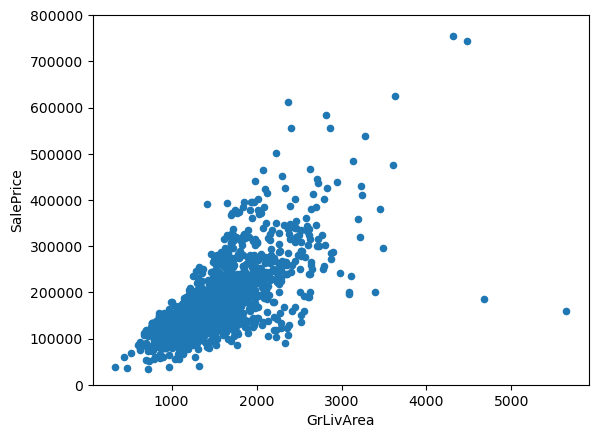

In [43]:
#scatter plot GrLivArea vs SalePrice. GrLivArea: Above grade (ground) living area square feet
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

There is a positive correlation between above ground living area square feet and SalePrice.

Text(0.5, 1.0, 'Sale Price by TotalBsmtSF (Total square feet of basement area)')

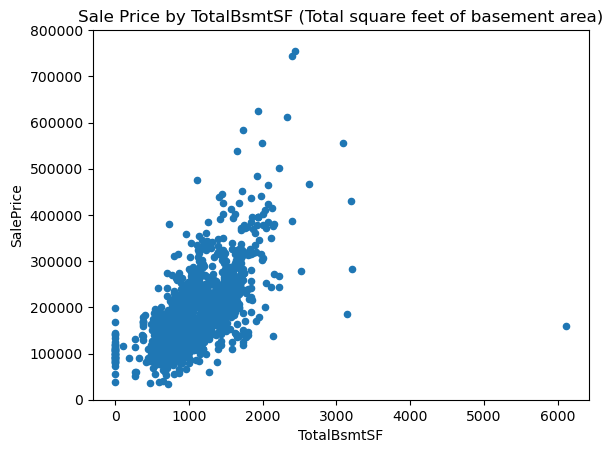

In [52]:
#scatter plot TotalBsmtSF vs SalePrice. TotalBsmtSF: Total square feet of basement area
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))
plt.title('Sale Price by TotalBsmtSF (Total square feet of basement area)')

There is also a positve correlation between Total square feet of basement area and the Sale Price.

### Relationship between SalePrice and categorical features¶

[Text(0.5, 1.0, 'Sale Price by Overall Quality')]

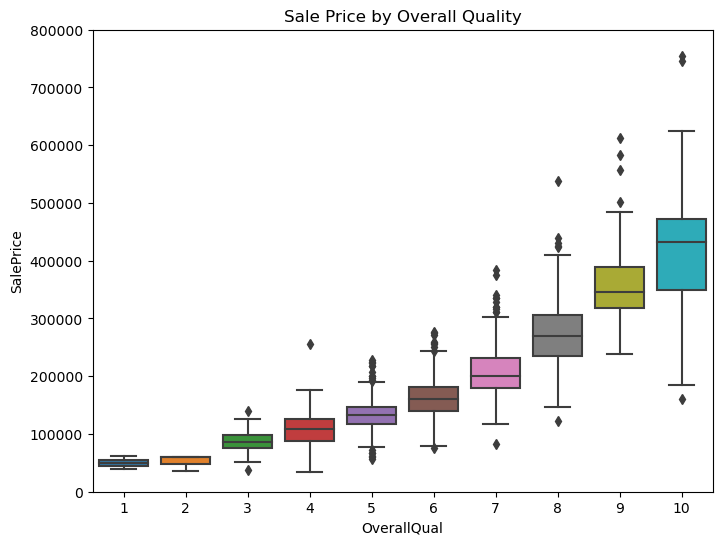

In [49]:
#box plot OverallQual vs SalePrice. 
#OverallQual: Rates the overall material and finish of the house, range from 1 to 10, 1 means very poor, and 10 means very excellent
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
fig.set(title='Sale Price by Overall Quality')

We can see from the box plot above the sale price increases as the indicator of overall material and finish of the house increases.

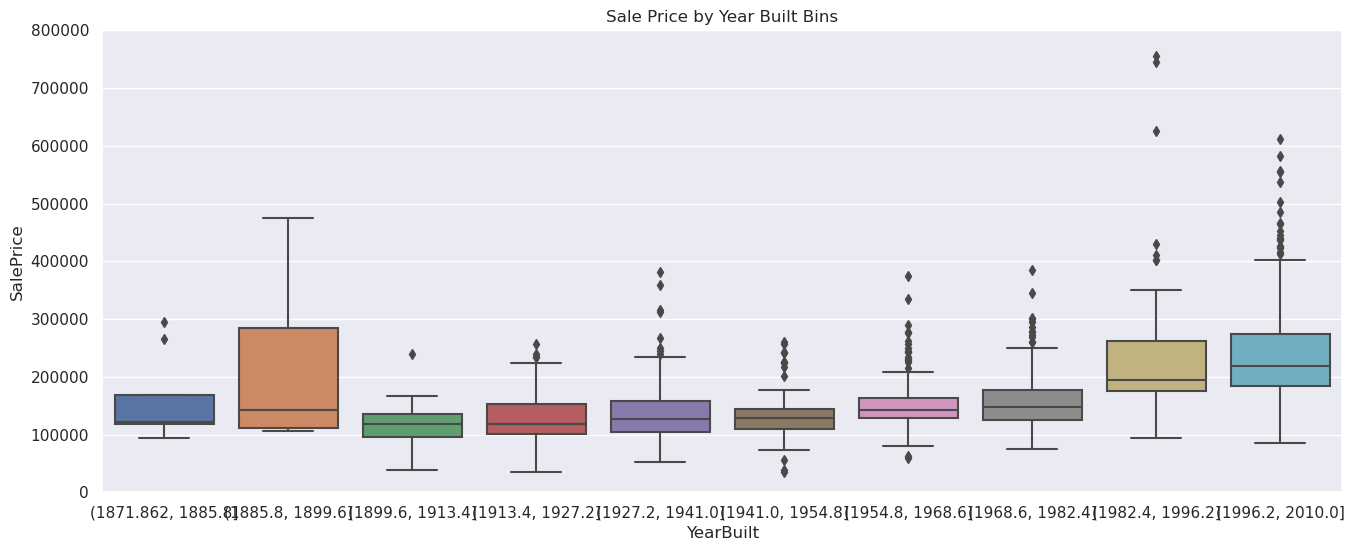

In [62]:
#box plot YearBuilt vs SalePrice. Here we divided YearBuilt into 10 bins for better visualization
var = 'YearBuilt'
YearBuiltBin =pd.cut( df_train[var].astype(int), 10)
data = pd.concat([df_train['SalePrice'],YearBuiltBin], axis=1)
f, ax = plt.subplots(figsize=(16, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.set(title='Sale Price by Year Built Bins')
fig.axis(ymin=0, ymax=800000);

There was a slight tendency that newer homes are associated with higher sale prices.

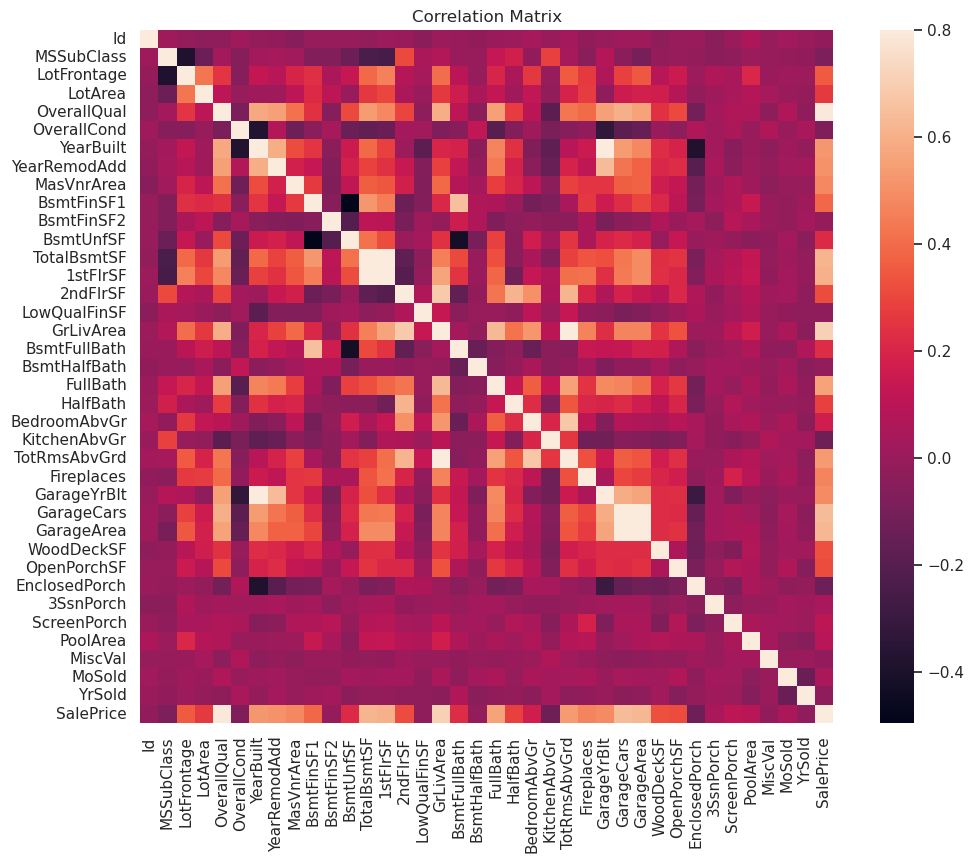

In [63]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True).set(title = 'Correlation Matrix');

In [64]:
# top 10 most correlated variables with SalePrice
corrmat.nlargest(10, 'SalePrice')['SalePrice']

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

The correlation matrix shows the most correlated variables are OverallQual with a correlation coefficient of 0.79, followed by GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF, and so on.



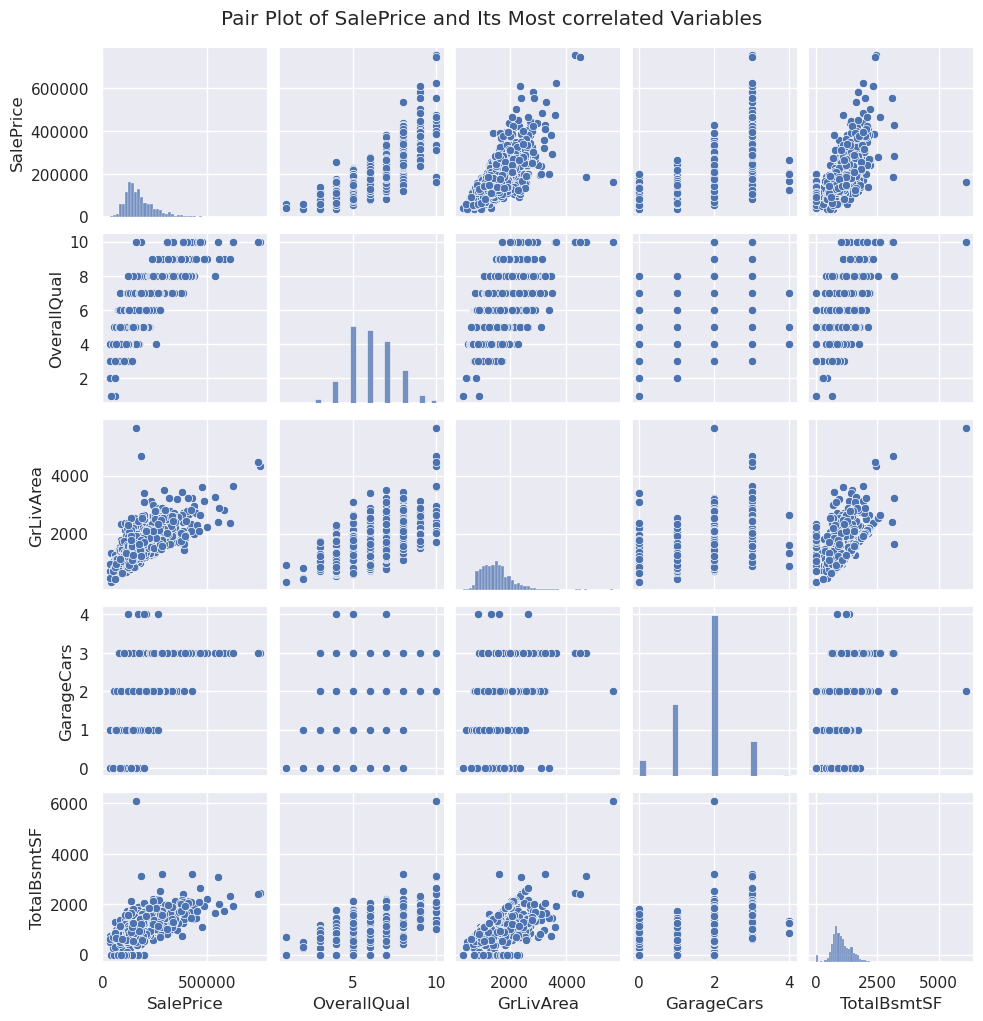

In [61]:
#scatterplot SalePrice and most correlated variables 
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF']
p = sns.pairplot(df_train[cols], height = 2)
p.fig.suptitle('Pair Plot of SalePrice and Its Most correlated Variables', y = 1.02) 
plt.show()

The scatter plot of 'TotalBsmtSF' and 'GrLiveArea' seems interesting. Almost all the data points are contrained in a border where 'GrLiveArea' is greater or equal to 'TotalBsmtSF'. It makes sense since basement areas is not expected to be bigger than the the living area above.

# Predicting prices with NLP model

We are going to apply a NLP model to predict house prices since we can treat all the predictors concatenated together as a sentence. The dataset will be split into training and evaluation subsets to be run through by a transformer model from the Torch module.

In [ ]:
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    PretrainedConfig,
    SchedulerType,
    default_data_collator,
    get_scheduler,
    BertModel
)

In [9]:
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    PretrainedConfig,
    SchedulerType,
    default_data_collator,
    get_scheduler,
    BertModel
)

In [10]:
class TransformerModel(nn.Module):

    def __init__(self, d_model: int = 768, dropout: float = 0.2, MODEL_NAME = None):
        super().__init__()
        self.model_type = 'Transformer'
        
        self.transformer_encoder = BertModel.from_pretrained(MODEL_NAME)
        self.decoder = torchvision.ops.MLP(in_channels=d_model,
                                       hidden_channels=[d_model, 1],
                                       activation_layer=torch.nn.GELU, inplace=None)
        self.regressor = torchvision.ops.MLP(in_channels=36,
                                       hidden_channels=[d_model, 1],
                                       activation_layer=torch.nn.GELU, inplace=None)
        
    def forward(self, src: Tensor, feature: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        output = self.transformer_encoder(src).last_hidden_state[0,0,:]
        output = self.decoder(output) + self.regressor(feature)
        return output

In [11]:
# create a function to concatenate variable name with variable value and form a sentence for each row
def df2text(df):
    text_lst = []
    header = list(df.columns)
    for index, row in df.iterrows():
        text = [header[ctr] +"="+str(tok) for ctr, tok in enumerate(row.values.tolist())]
        text_lst.append(",".join(text))
    return text_lst

In [12]:
#create a function to form a variable value only sentence for each rwo
def df2num(df):
    num_lst = []
    for index, row in df.iterrows():
        num_lst.append(row.values.tolist())
    return num_lst

In [13]:
class custom_vocab:
    def __init__(self):
        self.mapping = {}
        
    def add_token(self, token):
        if token not in self.mapping:
            self.mapping[token] = len(self.mapping) + 1
        return
    
    def process(self, text):
        output = []
        for token in text.split("/"):
            self.add_token(token)
            output.append(self.mapping[token])
        return np.asarray(output)

In [14]:
def data_process(raw_text_iter, tokenizer):
    """Converts raw text into a flat Tensor."""
    data_lst = []
    for item in raw_text_iter:
        tokens = tokenizer.tokenize(item) 
        tokens = ['[CLS]'] + tokens + ['[SEP]'] 
        #Obtain the indices of the tokens in the BERT Vocabulary
        input_ids = tokenizer.convert_tokens_to_ids(tokens)[0:512]
        data_lst.append(torch.tensor(input_ids, dtype=torch.long))
    return data_lst

In [15]:
def number_process(raw_num_iter):
    """Converts raw number into a flat Tensor."""
    data = [torch.tensor(item, dtype=torch.float) for item in raw_num_iter]
    return data

In [16]:
# create a function to fill missing values in predictors and apply the two processing functions above to the training dataset
def df_process(df_train, tokenizer):
    df_train_x = df_train.drop(columns="SalePrice")
    df_train_num = df_train_x.select_dtypes(include=[float, int])
    df_train_num.fillna(0, inplace=True)
    df_train_x.fillna('NA', inplace=True)
    
    train_x = df2text(df_train_x)
    train_y = df_train["SalePrice"].tolist()

    train_x_tsor = data_process(train_x, tokenizer)
    train_x_num = df2num(df_train_num)
    train_x_numtsor = number_process(train_x_num)
    train_y_tsor = [torch.tensor([_], dtype=torch.float) for _ in train_y]
    
    return train_x_tsor, train_x_numtsor, train_y_tsor
    

In [20]:
#Model configuration for a bert-base-uncased model
MODEL_NAME = 'bert-base-uncased'
DEVICE = torch.device("cpu", 0)

config = AutoConfig.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Train test split

In [32]:
df_train = df_train.drop(columns="Id")

df_train_set, df_eval_set = train_test_split(df_train, test_size=0.1)

train_x_tsor, train_x_numtsor, train_y_tsor = df_process(df_train=df_train_set, tokenizer=tokenizer)
eval_x_tsor, eval_x_numtsor, eval_y_tsor = df_process(df_train=df_eval_set, tokenizer=tokenizer)

df_test = df_test.drop(columns="Id")
df_test_num = df_test.select_dtypes(include=[float, int])
test_x = df2text(df_test)

test_x_tsor = data_process(test_x, tokenizer)
test_x_num = df2num(df_test_num)
test_x_numtsor = number_process(test_x_num)

Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors


In [33]:
model = TransformerModel(d_model=768, dropout=0.2, MODEL_NAME=MODEL_NAME).to(DEVICE)

criterion = torch.nn.MSELoss()
lr = 0.01  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
print("TRAIN DATA LEN:", len(train_x_tsor))

TRAIN DATA LEN: 1314


### Model Visualization

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


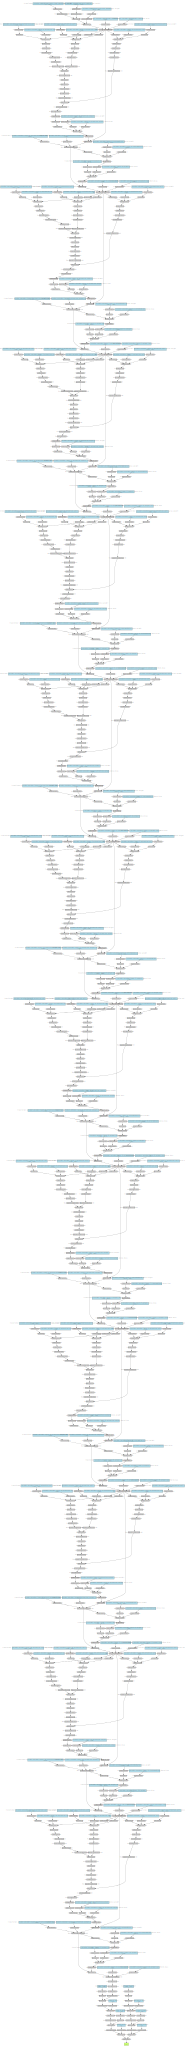

In [35]:
for step, (data, feature, output) in enumerate(zip(train_x_tsor, train_x_numtsor, train_y_tsor)):
    data, feature, output = data.to(DEVICE), feature.to(DEVICE), output.to(DEVICE)
    data = data.unsqueeze(0)
    model_output = model(data, feature)
    break
make_dot(model_output, params=dict(model.named_parameters()))

### Model Training and Evaluation

In [36]:
def evaluation(model, eval_set, criterion):
    loss_lst = []
    model.eval()
    (train_x_tsor, train_x_numtsor, train_y_tsor) = eval_set
    for step, (data, feature, output) in enumerate(zip(train_x_tsor, train_x_numtsor, train_y_tsor)):
        data, feature, output = data.to(DEVICE), feature.to(DEVICE), output.to(DEVICE)
        data = data.unsqueeze(0)
        with torch.no_grad():
            model_output = model(data, feature)

        loss = criterion(model_output, torch.log(output))
        loss_lst.append(loss.detach().cpu().numpy())
    return np.mean(loss_lst)

In [38]:
all_loss_lst = []
for epoch in range(30):
    loss_lst = []
    for step, (data, feature, output) in enumerate(zip(train_x_tsor, train_x_numtsor, train_y_tsor)):
        data, feature, output = data.to(DEVICE), feature.to(DEVICE), output.to(DEVICE)
        data = data.unsqueeze(0)
        model_output = model(data, feature)

        loss = criterion(model_output, torch.log(output))
        loss.backward()
        if step % 20 == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            optimizer.zero_grad()
        loss_lst.append(loss.detach().cpu().numpy())
        
    
    eval_loss = evaluation(model, eval_set=(eval_x_tsor, eval_x_numtsor, eval_y_tsor), criterion=criterion)
    print("EPOCH: {}, TRAIN LOSS={:10.4f}, EVAL LOSS={:10.4f}".format(epoch, np.mean(loss_lst), eval_loss))
    all_loss_lst.append(np.mean(loss_lst))

EPOCH: 0, TRAIN LOSS=954955.8125, EVAL LOSS= 1753.8933
EPOCH: 1, TRAIN LOSS=  182.7938, EVAL LOSS= 1258.9294


KeyboardInterrupt: 

The full results is listed as follows with 'cuda' as the device type
* EPOCH: 0, TRAIN LOSS=656897.8125, EVAL LOSS=   10.3833 
* EPOCH: 1, TRAIN LOSS= 1197.0559, EVAL LOSS=    0.4838 
* EPOCH: 2, TRAIN LOSS=  688.9999, EVAL LOSS=    0.1851
* EPOCH: 3, TRAIN LOSS=    0.3756, EVAL LOSS=    0.1924
* EPOCH: 4, TRAIN LOSS=    0.3859, EVAL LOSS=    0.1874
* EPOCH: 5, TRAIN LOSS=    0.3100, EVAL LOSS=    0.3006
* EPOCH: 6, TRAIN LOSS=    0.3619, EVAL LOSS=    0.2171
* EPOCH: 7, TRAIN LOSS=    0.4210, EVAL LOSS=    0.8037
* EPOCH: 8, TRAIN LOSS=    0.2634, EVAL LOSS=    0.7029
* EPOCH: 9, TRAIN LOSS=    0.2504, EVAL LOSS=    0.6490
* EPOCH: 10, TRAIN LOSS=    0.2625, EVAL LOSS=    0.3095
* EPOCH: 11, TRAIN LOSS=    0.2665, EVAL LOSS=    0.1791
* EPOCH: 12, TRAIN LOSS=    0.2683, EVAL LOSS=    0.1982
* EPOCH: 13, TRAIN LOSS=    0.2600, EVAL LOSS=    0.2926
* EPOCH: 14, TRAIN LOSS=    0.2103, EVAL LOSS=    0.2217
* EPOCH: 15, TRAIN LOSS=    0.1931, EVAL LOSS=    0.1973
* EPOCH: 16, TRAIN LOSS=    0.3194, EVAL LOSS=    0.1887
* EPOCH: 17, TRAIN LOSS=    0.3382, EVAL LOSS=    0.1826
* EPOCH: 18, TRAIN LOSS=    0.2694, EVAL LOSS=    0.2701
* EPOCH: 19, TRAIN LOSS=    0.3777, EVAL LOSS=    0.1999
* EPOCH: 20, TRAIN LOSS=    0.3073, EVAL LOSS=    0.3937
* EPOCH: 21, TRAIN LOSS=    0.3401, EVAL LOSS=    0.1924
* EPOCH: 22, TRAIN LOSS=    0.3103, EVAL LOSS=    0.2367
* EPOCH: 23, TRAIN LOSS=    0.2720, EVAL LOSS=    0.2165
* EPOCH: 24, TRAIN LOSS=    0.2579, EVAL LOSS=    0.2582
* EPOCH: 25, TRAIN LOSS=    0.1838, EVAL LOSS=    0.2416
* EPOCH: 26, TRAIN LOSS=    0.2179, EVAL LOSS=    0.1911
* EPOCH: 27, TRAIN LOSS=    0.2606, EVAL LOSS=    0.2005
* EPOCH: 28, TRAIN LOSS=    0.2191, EVAL LOSS=    0.1793
* EPOCH: 29, TRAIN LOSS=    0.2310, EVAL LOSS=    0.2333
* EPOCH: 30, TRAIN LOSS=    0.2413, EVAL LOSS=    0.1828
* EPOCH: 31, TRAIN LOSS=    0.2158, EVAL LOSS=    0.2197
* EPOCH: 32, TRAIN LOSS=    0.2219, EVAL LOSS=    0.2921
* EPOCH: 33, TRAIN LOSS=    0.2194, EVAL LOSS=    0.2476
* EPOCH: 34, TRAIN LOSS=    0.2136, EVAL LOSS=    0.2784
* EPOCH: 35, TRAIN LOSS=    0.2045, EVAL LOSS=    0.1805